In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier,plot_importance
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import warnings     
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle
import pickle


# 1. EDA 

In [2]:
df = pd.read_csv('exercise_angles.csv')
print(f"Dataset shape: {df.shape}")
print('###############################################')
print("\nMissing values per column:")
print(df.isnull().sum())
label_column = 'Label' 

if label_column in df.columns:
    unique_classes = df[label_column].nunique()
    print('###############################################')
    print(f"\nNumber of unique classes in '{label_column}': {unique_classes}")
else:
    print(f"\nColumn '{label_column}' not found in the dataset. Please specify the correct label column name.")

Dataset shape: (31033, 12)
###############################################

Missing values per column:
Side                     0
Shoulder_Angle           0
Elbow_Angle              0
Hip_Angle                0
Knee_Angle               0
Ankle_Angle              0
Shoulder_Ground_Angle    0
Elbow_Ground_Angle       0
Hip_Ground_Angle         0
Knee_Ground_Angle        0
Ankle_Ground_Angle       0
Label                    0
dtype: int64
###############################################

Number of unique classes in 'Label': 5


In [18]:
df.value_counts()

Shoulder_Angle  Elbow_Angle  Hip_Angle   Knee_Angle  Ankle_Angle  Shoulder_Ground_Angle  Elbow_Ground_Angle  Hip_Ground_Angle  Knee_Ground_Angle  Ankle_Ground_Angle  Label
0.002748        90.129080    133.343708  128.784963  163.253926   90.0                   90.0                90.0              90.0               90.0                4        1
74.188720       39.841327    65.395392   66.548833   141.044451   90.0                   90.0                90.0              90.0               90.0                1        1
74.506989       52.051165    33.437671   142.474097  47.855922    90.0                   90.0                90.0              90.0               90.0                1        1
74.502564       178.835983   174.468851  178.225935  177.649246   90.0                   90.0                90.0              90.0               90.0                0        1
74.474761       171.768758   162.103904  174.033359  115.095335   90.0                   90.0                90.0       

In [4]:
if 'Side' in df.columns:
    unique_values = df['Side'].unique()  # This returns an array of unique values
    num_unique = df['Side'].nunique()      # This returns the count of unique values
    print("Unique values in 'side':", unique_values)
    print("Number of unique values in 'side':", num_unique)

Unique values in 'side': ['left']
Number of unique values in 'side': 1


In [5]:
 df = df.drop(columns=['Side']) # remove this column

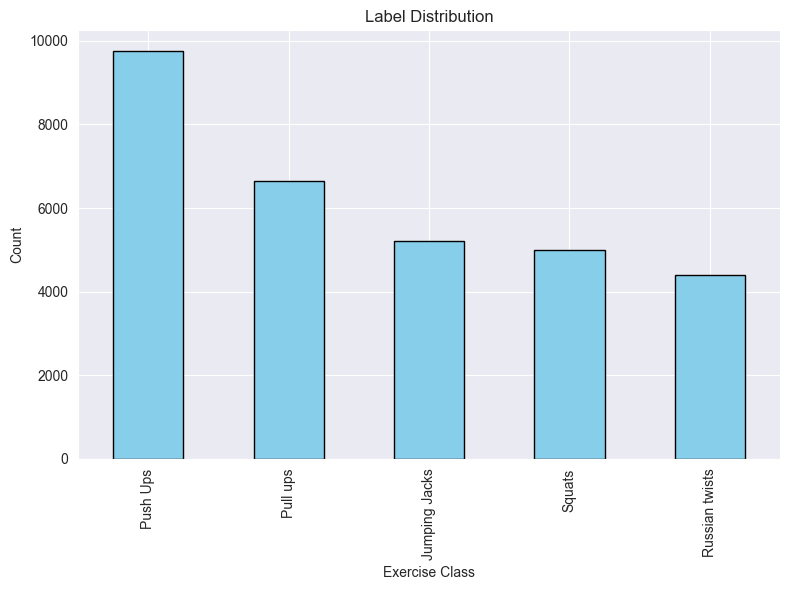

In [6]:
label_col = 'Label'

# Check if the label column exists and build the distribution graph
if label_col in df.columns:
    # Calculate the count of each exercise class
    label_counts = df[label_col].value_counts()
    
    # Plotting
    plt.figure(figsize=(8, 6))
    label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Label Distribution")
    plt.xlabel("Exercise Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [7]:

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

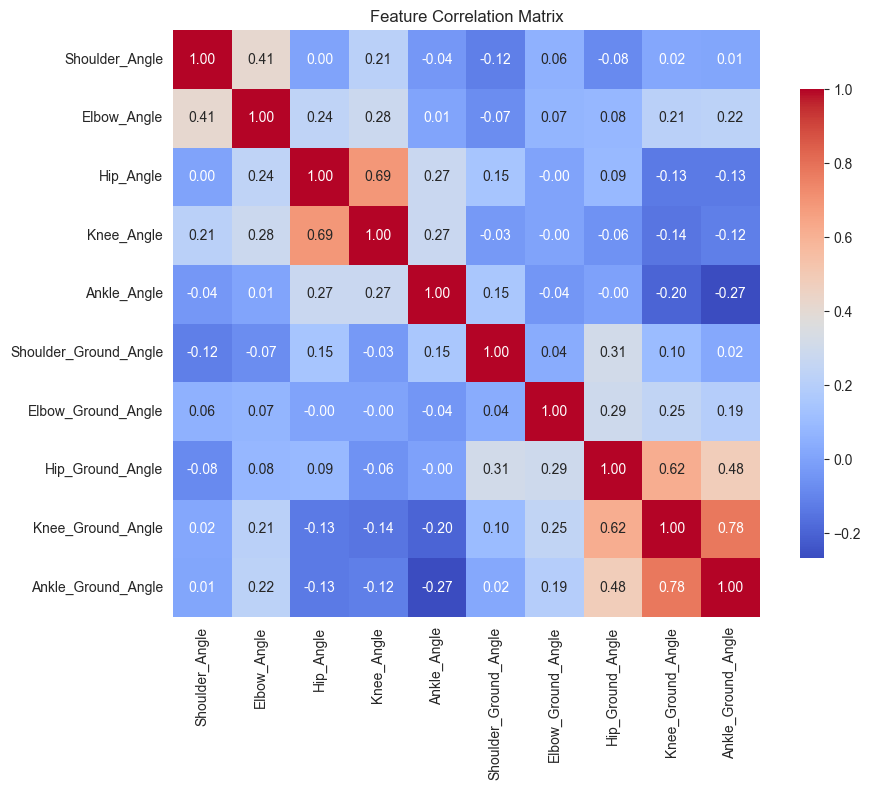

In [8]:
numeric_cols = df.select_dtypes(include="number").columns          # names only
numeric_df   = df[numeric_cols]                                    # actual data

# drop any numeric columns that are constant
numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]
corr = numeric_df.corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

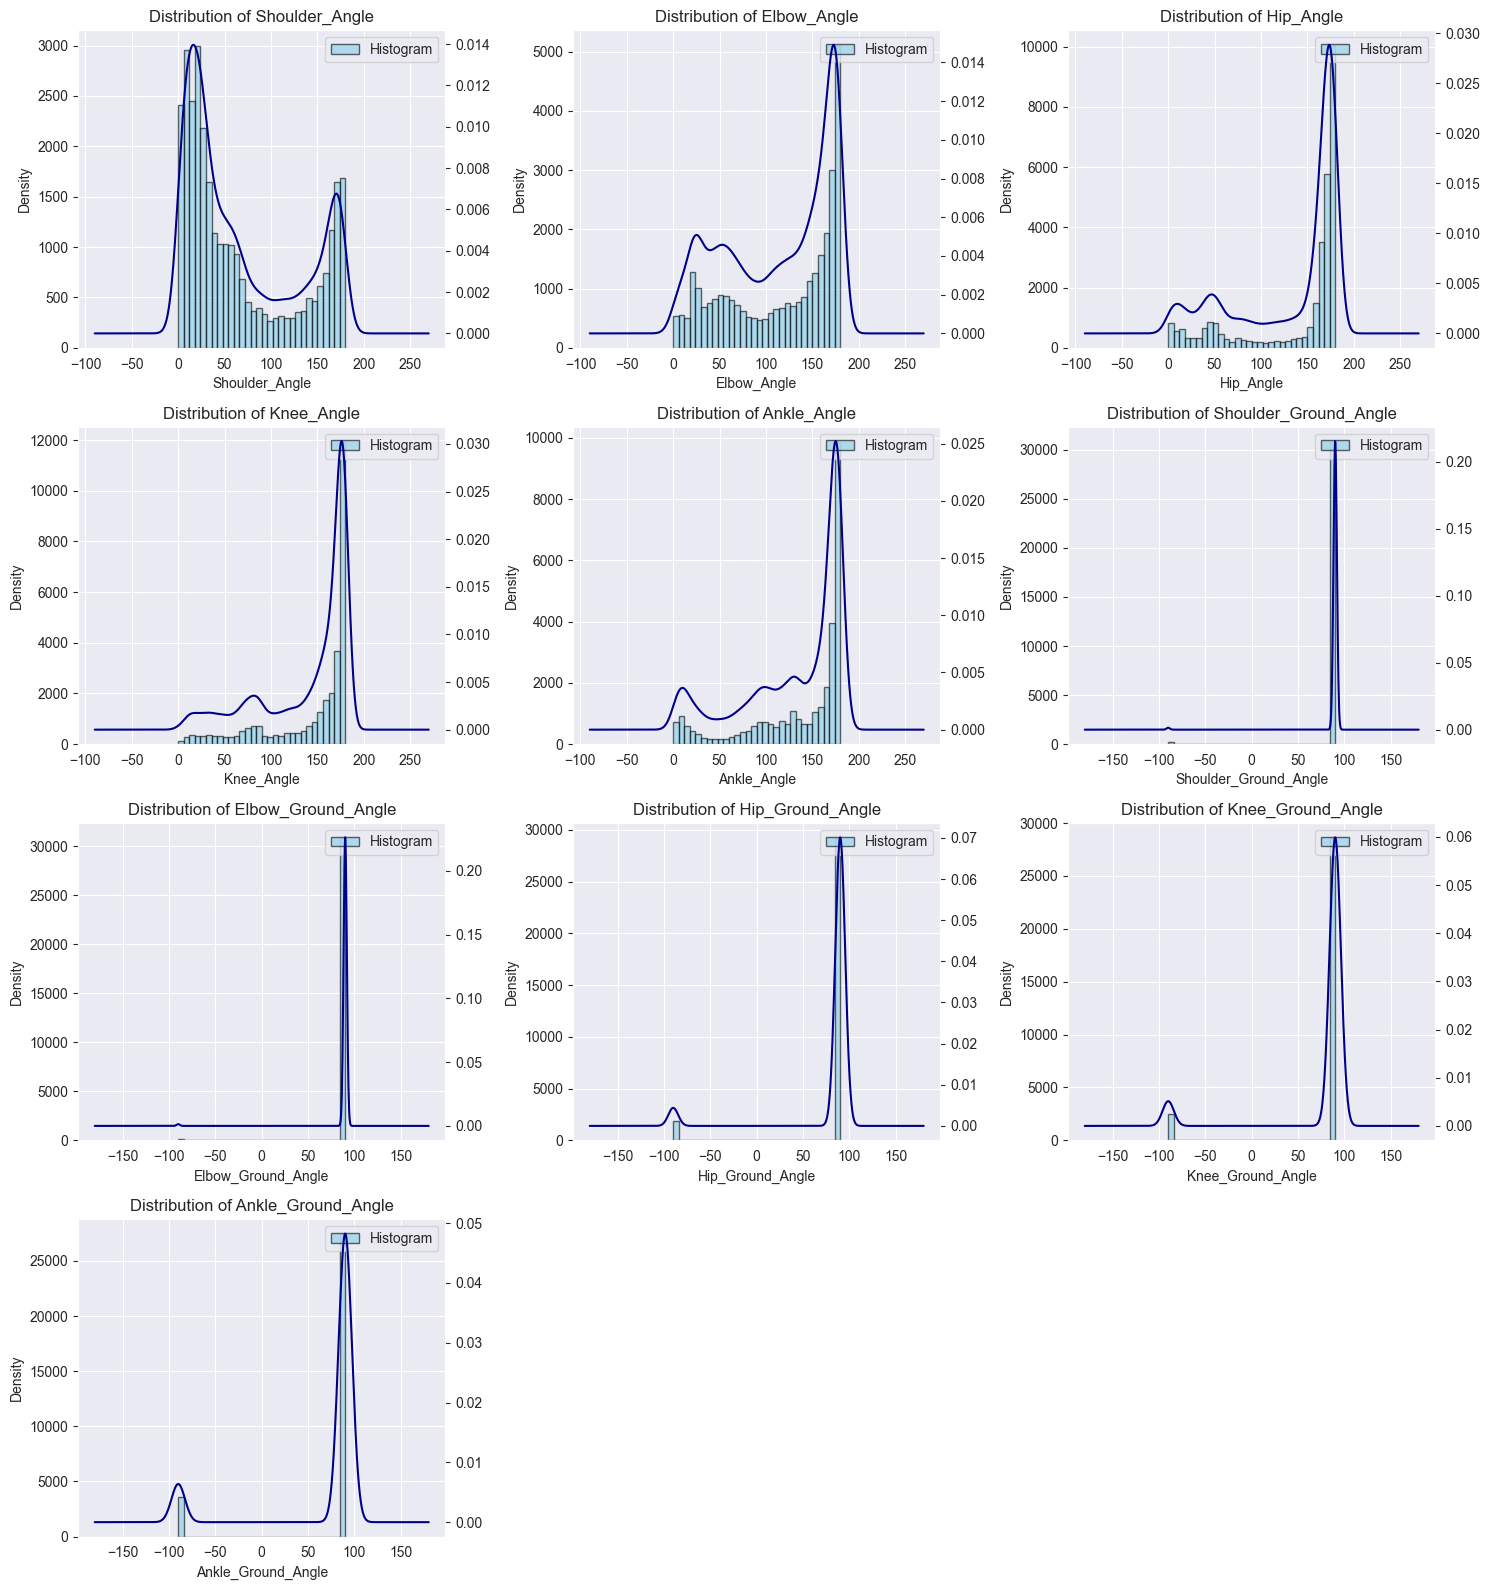

In [9]:
n_features = len(numeric_cols)
n_cols = 3  
n_rows = (n_features // n_cols) + int(n_features % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()  

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    # Plot histogram
    ax.hist(df[col].dropna(), bins=30, alpha=0.6, label='Histogram', color='skyblue', edgecolor='black')
    df[col].plot(kind='density', ax=ax, secondary_y=True, color='darkblue', label='Density')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.legend(loc='upper right')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

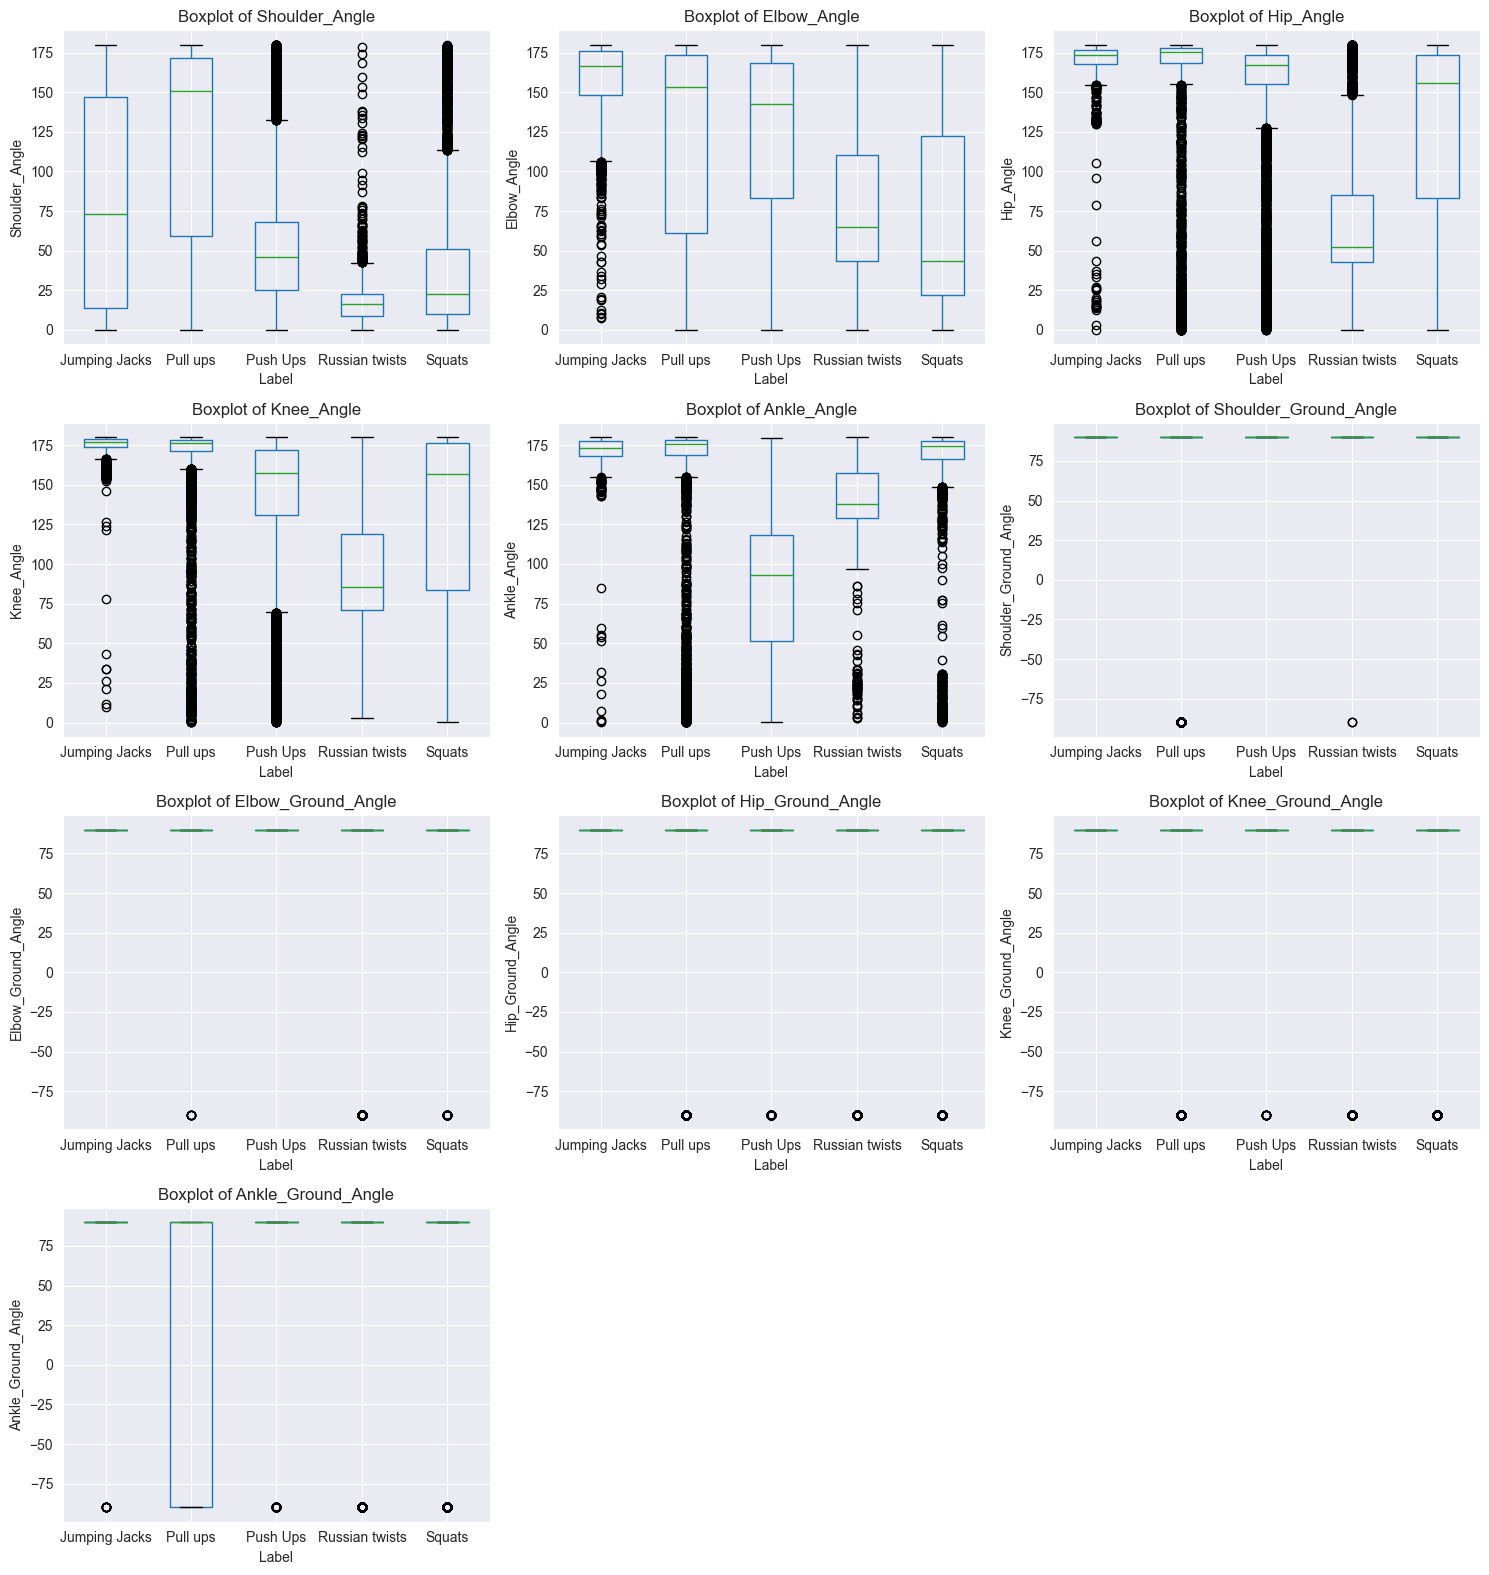

In [10]:
label_col = 'Label'
numeric_cols = [col for col in df.select_dtypes(include=['float', 'int']).columns if col != label_col]

if label_col in df.columns:
    n_features = len(numeric_cols)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        df.boxplot(column=col, by=label_col, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(label_col)
        axes[i].set_ylabel(col)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('')
    plt.tight_layout()
    plt.show()

#### From the plot above, it appears that we can drop some features that are unnecessary for the classification task. For example, both the feature distribution histograms and box plots indicate that the feature "Shoulder_Ground_Angle" remains constant across all instances in the dataset. The same observation applies to all the "Ground_angle" features.
#### Our approach will be to build two classifiers: one that includes the "Ground angle" features and one that does not. We will then compare their performances. If the classifier without the "Ground angle" features yields sufficient accuracy, it will reduce the model complexity and facilitate a more efficient real-time body detection system.

# 2. Classification Model


#### Train, Validation, Test Split

In [11]:
label_col = 'Label'
le = LabelEncoder()
df[label_col] = le.fit_transform(df[label_col])
X = df.drop(columns=[label_col])
y = df[label_col]
# 70% train set
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
# 15% test set and 15% validation set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
with open('y_testset.pkl', 'wb') as f:
    pickle.dump((y_test), f)
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (21723, 10) (21723,)
Validation set shape: (4655, 10) (4655,)
Test set shape: (4655, 10) (4655,)


#### Normalize features for model 1 (contains all features)

In [12]:
scaler = StandardScaler()
# For Model 1 (all features)
X_train_all = scaler.fit_transform(X_train)
with open('trainset_all_features.pkl', 'wb') as f:
    pickle.dump((X_train_all), f)
X_val_all   = scaler.transform(X_val)
X_test_all  = scaler.transform(X_test)


#### Normalize features for model 2 (without 'Ground_Angle' features)

In [13]:
columns_to_drop = [col for col in X.columns if 'Ground_Angle' in col]

# Create reduced feature sets for Model 2 (dropping Ground_Angle features)
X_train_red = X_train.drop(columns=columns_to_drop)
X_val_red   = X_val.drop(columns=columns_to_drop)
X_test_red  = X_test.drop(columns=columns_to_drop)
# print(X_train_red)
with open('trainset.pkl', 'wb') as f:
    pickle.dump((X_train_red), f)
with open('testset.pkl', 'wb') as f:
    pickle.dump((X_test_red), f)
# Normalize the reduced feature sets
scaler_red = StandardScaler()
X_train_red = scaler_red.fit_transform(X_train_red)
X_val_red   = scaler_red.transform(X_val_red)
X_test_red  = scaler_red.transform(X_test_red)
# print(X_train_red)

#### Train model 1 : Using all features

In [14]:
model_all_rf = RandomForestClassifier(random_state=42)

# Train the Random Forest classifier using all features (normalized data)
model_all_rf.fit(X_train_all, y_train)

RandomForestClassifier(random_state=42)

#### Train model 2: Using reduced features (without Ground_Angle features)

In [15]:
model_red_rf = RandomForestClassifier(random_state=42)
model_red_rf.fit(X_train_red, y_train)

RandomForestClassifier(random_state=42)

#### Calculate accuracy on the validation set

In [16]:
y_val_pred_all = model_all_rf.predict(X_val_all)
acc_all = accuracy_score(y_val, y_val_pred_all)
f1_all = f1_score(y_val, y_val_pred_all, average='weighted')  # Use weighted average for multiclass

print("\nValidation Accuracy (All Features): {:.2f}%".format(acc_all * 100))
print("Validation F1 Score (All Features): {:.2f}".format(f1_all))

# --- Model 2: Predictions using reduced features (without Ground_Angle features) ---
y_val_pred_red = model_red_rf.predict(X_val_red)
acc_red = accuracy_score(y_val, y_val_pred_red)
f1_red = f1_score(y_val, y_val_pred_red, average='weighted')  # Use weighted average for multiclass

print("Validation Accuracy (Without Ground_Angle Features): {:.2f}%".format(acc_red * 100))
print("Validation F1 Score (Without Ground_Angle Features): {:.2f}".format(f1_red))


Validation Accuracy (All Features): 96.39%
Validation F1 Score (All Features): 0.96
Validation Accuracy (Without Ground_Angle Features): 95.25%
Validation F1 Score (Without Ground_Angle Features): 0.95


#### Use feature importance plot for model 1, to check if the 'Ground_Angle' features are really less important

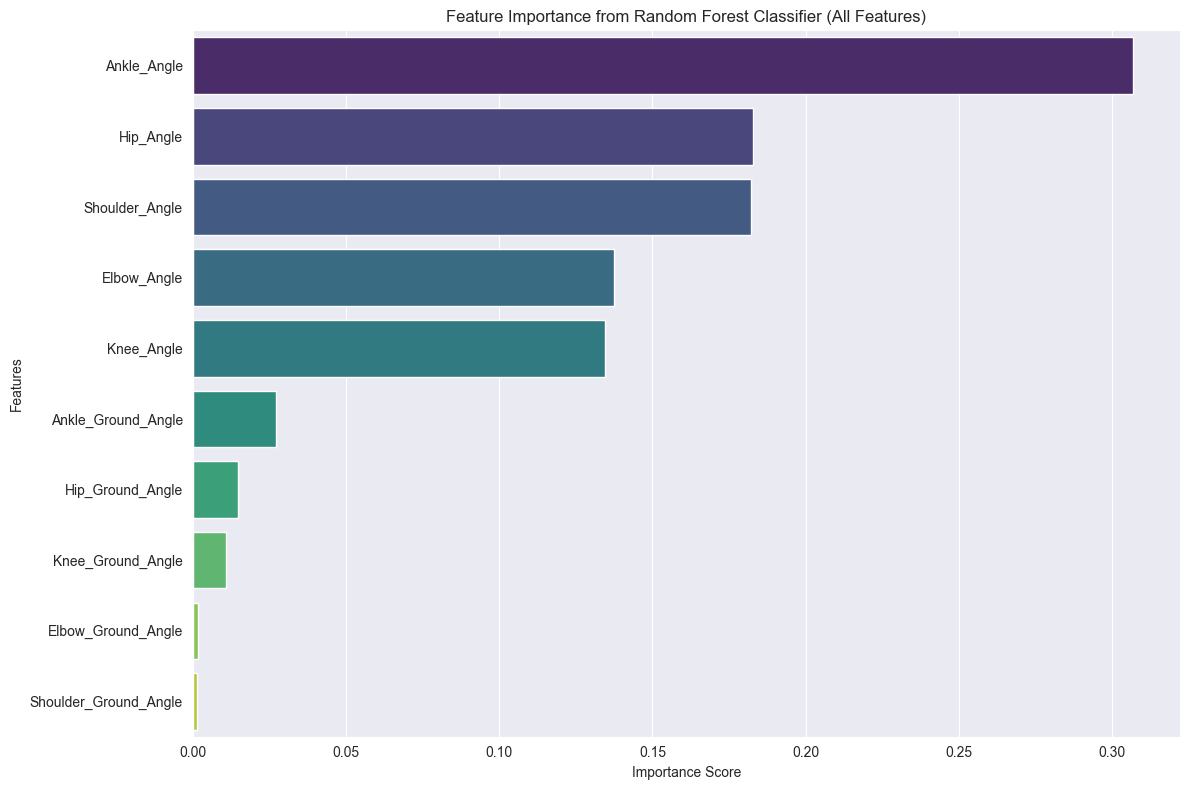

In [17]:
warnings.filterwarnings("ignore")
feature_names = X_train.columns

# XGBoost classifier has the attribute 'feature_importances_'
importances = model_all_rf.feature_importances_

# Create a DataFrame for easier plotting
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance (descending order)
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest Classifier (All Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

#### From the feature importance plot and from the accuracy and F1 scores on the validation set, it looks like we can use model 2 for creating classification. It will ease our real time video model that should calculate the angles between the body parts in real time. 

#### Test model 2 on the test set, and calculate AUC-ROC and precision - recall curve:

In [110]:
y_test_pred_rf = model_red_rf.predict(X_test_red)
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')  # using weighted F1 for multiclass

print("Test Accuracy: {:.2f}%".format(accuracy_rf * 100))
print("Test F1 Score: {:.2f}".format(f1_rf))

Test Accuracy: 94.97%
Test F1 Score: 0.95


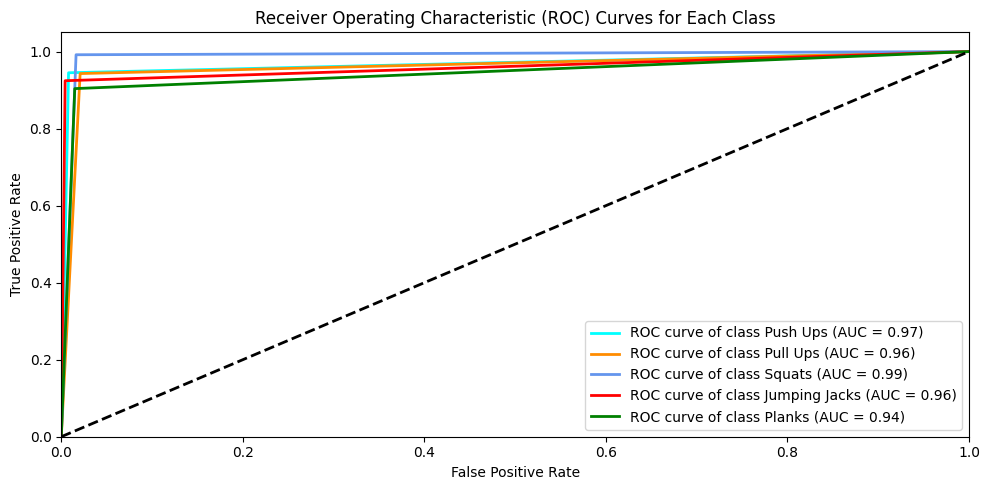

In [111]:
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
y_pred_bin = label_binarize(y_test_pred_rf, classes=range(len(le.classes_)))
label_map = {
    0: "Push Ups",
    1: "Pull Ups",
    2: "Squats",
    3: "Jumping Jacks",
    4: "Planks"
}
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a color cycle for differentiating the classes
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green',
                'purple', 'brown', 'pink', 'gray', 'olive'])

plt.figure(figsize=(10, 5))
for i, color in zip(range(n_classes), colors):
    # Convert the class label to string to display its name
    class_name = str(le.classes_[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(label_map[int(class_name)], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Each Class')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [112]:
# Save the model_red_rf (reduced features) to a pickle file
with open('model_red_rf.pkl', 'wb') as f:
    pickle.dump(model_red_rf, f)

print("Model saved as 'model_red_rf.pkl'")

Model saved as 'model_red_rf.pkl'
